In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
import glob
import random
import tensorflow as tf

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model, Sequential

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17001711050750406772
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1745302324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14081470337527329236
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Установите лимит использования GPU, например, 50%
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=0.7)]
        )
    except RuntimeError as e:
        print(e)

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

Исходный датасет

In [8]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33913 entries, 0 to 33912
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            33913 non-null  object
 1   class         33913 non-null  object
 2   segmentation  33913 non-null  object
 3   img_path      33913 non-null  object
 4   WIDTH         33913 non-null  int64 
 5   HEIGHT        33913 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.6+ MB


In [9]:
len(data['id'].unique())

16590

In [10]:
data.shape

(33913, 6)

In [11]:
data.head()

,id,class,segmentation,img_path,WIDTH,HEIGHT
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,../uw-madison-gi-tract-image-segmentation/trai...,266,266
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,../uw-madison-gi-tract-image-segmentation/trai...,266,266
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,../uw-madison-gi-tract-image-segmentation/trai...,266,266
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,../uw-madison-gi-tract-image-segmentation/trai...,266,266
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,../uw-madison-gi-tract-image-segmentation/trai...,266,266


Функция, декодирующая rle-закодированнеы маски

In [12]:
def rle2mask(mask_rle, shape=(266, 266)):
    
    if isinstance(mask_rle, float) and np.isnan(mask_rle):
        return np.zeros(shape, dtype=np.uint8)
        
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape)

Фунцкция, для получения пути до исходного изображения

In [13]:
def transform_path(original_path):
    parts = original_path.split('/')
    case_day = parts[-3]
    slice_info = parts[-1].split('_')[1:4]  # slice_0067_266_266_1.50_1.50.png -> [0067, 266, 266]
    slice_number = slice_info[0]
    # Сформировать новый путь
    new_path = f"/{case_day}_slice_{slice_number}.png"
    return "imgs" + new_path

In [14]:
data['img_path'] = data['img_path'].apply(transform_path)

In [15]:
data.head()

,id,class,segmentation,img_path,WIDTH,HEIGHT
0,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,imgs/case123_day20_slice_0065.png,266,266
1,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,imgs/case123_day20_slice_0066.png,266,266
2,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,imgs/case123_day20_slice_0067.png,266,266
3,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,imgs/case123_day20_slice_0068.png,266,266
4,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,imgs/case123_day20_slice_0069.png,266,266


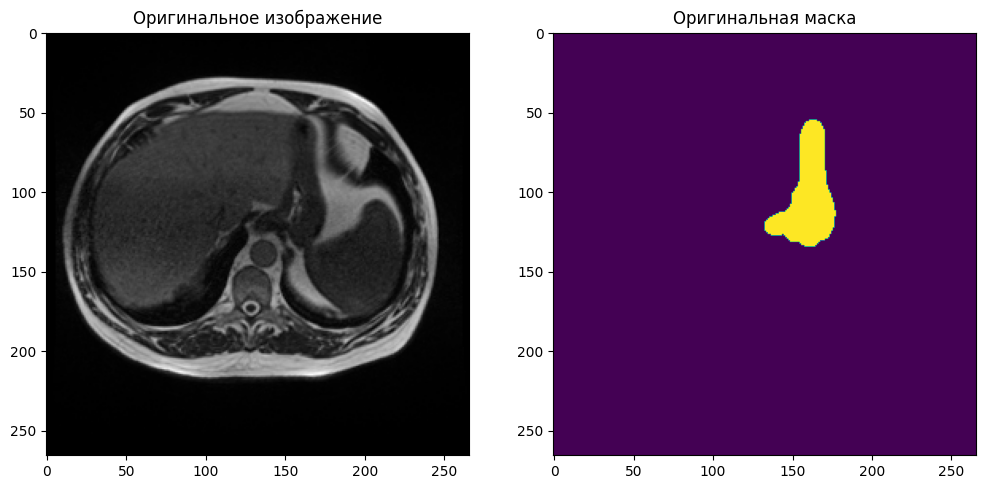

In [16]:
img = cv2.imread(data['img_path'].iloc[3])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)  
plt.title('Оригинальное изображение')

mymaska = rle2mask(data['segmentation'].iloc[3])

plt.subplot(1, 2, 2)
plt.imshow(mymaska)  
plt.title('Оригинальная маска')

plt.show()

Создание нового датафрейма, содержащего все маски конкретного изображения в одной строке

In [17]:
grouped = data.groupby('id')

new_dataset = pd.DataFrame()

for name, group in grouped:
    new_row = {'id': name, 'img_path': group['img_path'].iloc[0], 'WIDTH': group['WIDTH'].iloc[0], 'HEIGHT': group['HEIGHT'].iloc[0]}
    for index, row in group.iterrows():
        new_row[row['class']] = row['segmentation']
    temp_df = pd.DataFrame([new_row])
    new_dataset = pd.concat([new_dataset, temp_df], ignore_index=True)

In [18]:
new_dataset

,id,img_path,WIDTH,HEIGHT,stomach,large_bowel,small_bowel
0,case101_day20_slice_0066,imgs/case101_day20_slice_0066.png,266,266,32107 5 32371 10 32635 13 32900 15 33165 17 33...,NaN,NaN
1,case101_day20_slice_0067,imgs/case101_day20_slice_0067.png,266,266,31313 2 31577 7 31841 10 32105 14 32369 17 326...,NaN,NaN
2,case101_day20_slice_0068,imgs/case101_day20_slice_0068.png,266,266,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,NaN,NaN
3,case101_day20_slice_0069,imgs/case101_day20_slice_0069.png,266,266,29981 10 30246 13 30511 16 30776 19 31041 21 3...,NaN,NaN
4,case101_day20_slice_0070,imgs/case101_day20_slice_0070.png,266,266,28918 9 29182 14 29446 18 29711 21 29976 23 30...,NaN,NaN
...,...,...,...,...,...,...,...
16585,case9_day22_slice_0115,imgs/case9_day22_slice_0115.png,310,360,NaN,38022 2 38380 7 38739 9 39099 10 39295 6 39459...,21360 7 21718 10 22077 12 22435 15 22788 1 227...
16586,case9_day22_slice_0116,imgs/case9_day22_slice_0116.png,310,360,NaN,38021 4 38379 8 38739 10 38938 2 39099 10 3929...,21361 3 21718 9 22076 12 22435 14 22794 17 231...
16587,case9_day22_slice_0117,imgs/case9_day22_slice_0117.png,310,360,NaN,38020 7 38379 10 38738 12 38936 4 39098 12 392...,21717 8 22076 11 22434 15 22791 20 23149 25 23...
16588,case9_day22_slice_0118,imgs/case9_day22_slice_0118.png,310,360,NaN,37661 5 38019 10 38378 12 38738 12 39097 14 39...,21359 6 21717 10 22074 15 22431 20 22790 23 23...


Создание многоканальной маски

In [19]:
img_path_list = new_dataset['img_path'].tolist()

In [20]:
selected_columns = ['stomach', 'large_bowel', 'small_bowel']

mask_list = []

for index, row in new_dataset[selected_columns].iterrows():
    width = new_dataset.loc[index, 'WIDTH']
    height = new_dataset.loc[index, 'HEIGHT']
    
    masks = []
    for elem in row.tolist():
        mask = rle2mask(elem, shape=(width, height))
        mask = cv2.resize(mask, (256, 256))
        masks.append(mask)
    
    mask_list.append(masks)

In [21]:
mask_list_resized = np.array(mask_list)
mask_list_resized.shape

(16590, 3, 256, 256)

In [22]:
mask_list_resized = np.moveaxis(mask_list, 1, -1)

In [23]:
mask_list_resized.shape

(16590, 256, 256, 3)

Разделение на обучающую и тестовую выборки

In [24]:
img_train, img_test, mask_train, mask_test = train_test_split(img_path_list, mask_list_resized, test_size=0.2, random_state=42)

Создание модели Unet

In [25]:
def unet_model(image_size, output_classes):

    input_layer = Input(shape=image_size + (3,))
    
    conv_1 = Conv2D(64, 4, activation=LeakyReLU(),strides=2, padding='same', 
                    kernel_initializer='glorot_normal',use_bias=False)(input_layer)
    
    conv_1_1 = Conv2D(128, 4, activation=LeakyReLU(), strides=2,padding='same', 
                    kernel_initializer='glorot_normal',use_bias=False)(conv_1)

    batch_norm_1 = BatchNormalization()(conv_1_1)

    conv_2 = Conv2D(256, 4, activation=LeakyReLU(), strides=2,padding='same', 
                    kernel_initializer='glorot_normal',use_bias=False)(batch_norm_1)

    batch_norm_2 = BatchNormalization()(conv_2)

    conv_3 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,padding='same', 
                    kernel_initializer='glorot_normal',use_bias=False)(batch_norm_2)

    batch_norm_3 = BatchNormalization()(conv_3)

    conv_4 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,padding='same', 
                    kernel_initializer='glorot_normal',use_bias=False)(batch_norm_3)

    batch_norm_4 = BatchNormalization()(conv_4)

    conv_5 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,padding='same', 
                    kernel_initializer='glorot_normal',use_bias=False)(batch_norm_4)

    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,padding='same', 
                    kernel_initializer='glorot_normal',use_bias=False)(batch_norm_5)

    up_1 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                    padding='same',kernel_initializer='glorot_normal',use_bias=False)(conv_6), conv_5])

    batch_up_1 = BatchNormalization()(up_1)

    batch_up_1 = Dropout(0.25)(batch_up_1)

    up_2 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                    padding='same',kernel_initializer='glorot_normal',use_bias=False)(batch_up_1), conv_4])

    batch_up_2 = BatchNormalization()(up_2)

    batch_up_2 = Dropout(0.25)(batch_up_2)

    up_3 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,padding='same',
                    kernel_initializer='glorot_normal',use_bias=False)(batch_up_2), conv_3])

    batch_up_3 = BatchNormalization()(up_3)

    batch_up_3 = Dropout(0.25)(batch_up_3)

    up_4 = Concatenate()([Conv2DTranspose(256, 4, activation='relu', strides=2,padding='same',
                    kernel_initializer='glorot_normal',use_bias=False)(batch_up_3), conv_2])

    batch_up_4 = BatchNormalization()(up_4)

    up_5 = Concatenate()([Conv2DTranspose(128, 4, activation='relu', strides=2,padding='same',
                    kernel_initializer='glorot_normal',use_bias=False)(batch_up_4), conv_1_1])

    batch_up_5 = BatchNormalization()(up_5)

    up_6 = Concatenate()([Conv2DTranspose(64, 4, activation='relu', strides=2,padding='same',
                    kernel_initializer='glorot_normal',use_bias=False)(batch_up_5), conv_1])

    batch_up_6 = BatchNormalization()(up_6)

    output_layer = Conv2DTranspose(output_classes, 4, activation='sigmoid',
                    strides=2,padding='same',kernel_initializer='glorot_normal')(batch_up_6)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

Функция потерь, состоящия из dice и бинарной кросс-энтропии

In [26]:
def dice_coef(y_pred, y_true):
    y_pred_split = tf.split(y_pred, num_or_size_splits=3, axis=-1)
    y_true_split = tf.split(y_true, num_or_size_splits=3, axis=-1)
    dice_summ = 0

    for a_y_pred, b_y_true in zip(y_pred_split, y_true_split):
        dice_calculate = (2 * tf.reduce_sum(a_y_pred * b_y_true) + 1) / (tf.reduce_sum(a_y_pred + b_y_true) + 1)

        dice_summ += dice_calculate
    avg_dice = dice_summ / 3  
    return avg_dice

def dice_loss(y_pred, y_true):
    d_loss = 1 - dice_coef(y_pred, y_true)
    return d_loss


def loss_func(y_pred, y_true):
    total_loss =  0.4 * dice_loss(y_pred, y_true) + tf.keras.losses.binary_crossentropy(y_pred, y_true)
    return total_loss

Инициализация и компиляция модели

In [27]:
Segmentator = unet_model((256, 256), 3)

In [28]:
Segmentator.compile(optimizer='adam',loss=[loss_func], metrics=[dice_coef])

Segmentator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 128)  131072      ['conv2d[0][0]']                 
                                                                                              

Генератор данных, который поставляет данные в модель порциями

In [29]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 4, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):

    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]
    list_ids = [self.ids[i] for i in indexes]
    list_mask = [self.mask[i] for i in indexes]
    X, y = self.__data_generation(list_ids, list_mask)

    return X, y

  def on_epoch_end(self):
      
    self.indexes = np.arange(len(self.ids))
      
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
      
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 3))

    for i in range(len(list_ids)):
        
        img_path = str(list_ids[i])
  
        img = cv2.imread(img_path)
        
        mask = list_mask[i]

        img = cv2.resize(img, (self.img_h, self.img_w))

        X[i,] = img
        y[i,] = mask

    return X, y

In [30]:
train_data = DataGenerator(img_train, mask_train)
val_data = DataGenerator(img_test, mask_test)

Обучение модели

In [32]:
seg_h = Segmentator.fit(train_data, validation_data=val_data, epochs=10, initial_epoch=0)

Epoch 1/10
3318/3318 [==============================] - 421s 127ms/step - loss: 0.2374 - dice_coef: 0.5228 - val_loss: 0.1661 - val_dice_coef: 0.6571
Epoch 2/10
3318/3318 [==============================] - 421s 127ms/step - loss: 0.1350 - dice_coef: 0.7214 - val_loss: 0.1197 - val_dice_coef: 0.7531
Epoch 3/10
3318/3318 [==============================] - 419s 126ms/step - loss: 0.1070 - dice_coef: 0.7798 - val_loss: 0.1171 - val_dice_coef: 0.7645
Epoch 4/10
3318/3318 [==============================] - 424s 128ms/step - loss: 0.0911 - dice_coef: 0.8138 - val_loss: 0.0902 - val_dice_coef: 0.8152
Epoch 5/10
3318/3318 [==============================] - 425s 128ms/step - loss: 0.0830 - dice_coef: 0.8300 - val_loss: 0.0876 - val_dice_coef: 0.8232
Epoch 6/10
3318/3318 [==============================] - 424s 128ms/step - loss: 0.0752 - dice_coef: 0.8462 - val_loss: 0.0781 - val_dice_coef: 0.8423
Epoch 7/10
3318/3318 [==============================] - 415s 125ms/step - loss: 0.0713 - dice_coef: 

Построение графиков, отражающих результат обучения

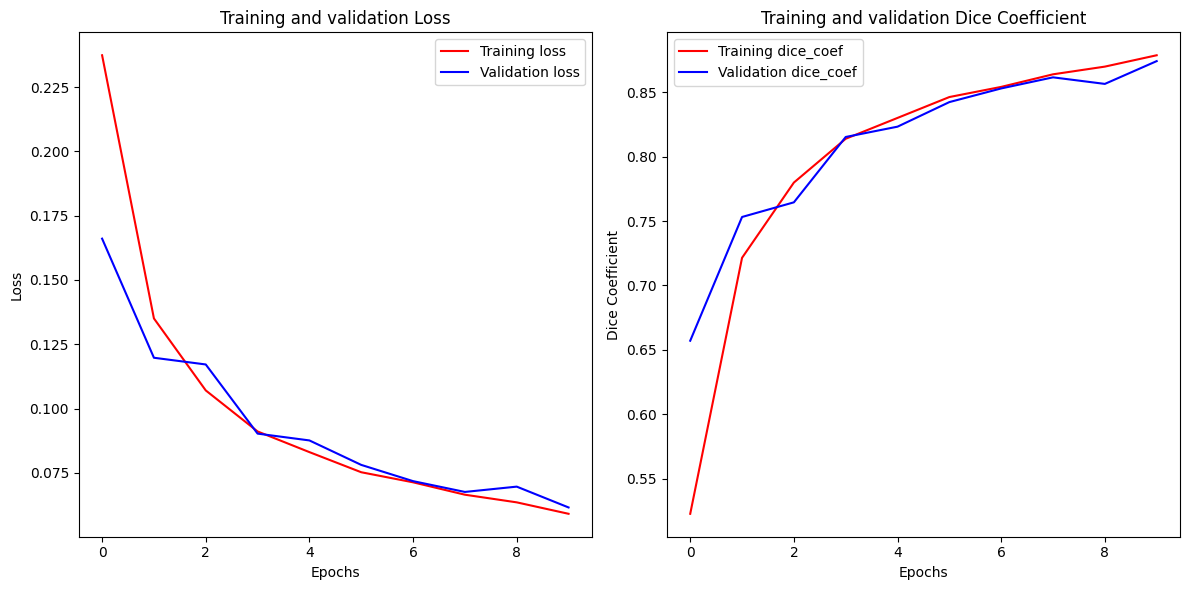

In [38]:
loss = seg_h.history['loss']
val_loss = seg_h.history['val_loss']
dice_coef = seg_h.history['dice_coef']
val_dice_coef = seg_h.history['val_dice_coef']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dice_coef, 'r', label='Training dice_coef')
plt.plot(val_dice_coef, 'b', label='Validation dice_coef')
plt.title('Training and validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()

Получение случайной картинки и ее предсказанной и оригинальной масок

In [99]:
img_path = new_dataset['img_path'].sample().iloc[0]
index_of_random_value = new_dataset[new_dataset['img_path'] == img_path].index[0]

In [100]:
original_mask = mask_list[index_of_random_value]
original_mask = np.array(original_mask)
original_mask = np.moveaxis(original_mask, 0, -1)

In [101]:
img = cv2.imread(img_path)
img = cv2.resize(img, (256,256))

In [102]:
img_batch = np.expand_dims(img, axis=0)
predict = Segmentator.predict(img_batch)
predicted_mask = predict[0]

1/1 [==============================] - 0s 22ms/step


In [103]:
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
class_colors = {0: RED, 1: GREEN, 2: BLUE} 

Создание оригинальной и предсказанной цветных масок

In [104]:
colored_original_masks = []

for class_index in range(original_mask.shape[-1]):
    
    class_mask = original_mask[..., class_index]
    colored_original_mask = np.zeros_like(original_mask)

    colored_original_mask[class_mask > 0.2] = class_colors[class_index]
    colored_original_masks.append(cv2.resize(colored_original_mask, (256,256)))

In [105]:
colored_predicted_masks = []

for class_index in range(predicted_mask.shape[-1]):
    class_mask = predicted_mask[..., class_index]
    colored_predicted_mask = np.zeros_like(img)
    
    colored_predicted_mask[class_mask > 0.5] = class_colors[class_index]
    colored_predicted_masks.append(colored_predicted_mask)

In [106]:
overlay_predicted = np.zeros_like(img)
overlay_original = np.zeros_like(img)

for colored_predicted_mask in colored_predicted_masks:
    overlay_predicted = cv2.addWeighted(overlay_predicted, 1, colored_predicted_mask, 1, 0)

for colored_original_mask in colored_original_masks:    
    overlay_original = cv2.addWeighted(overlay_original, 1, colored_original_mask, 1, 0)

Наложение масок поверх оригинальных изображений

In [107]:
result_original = cv2.addWeighted(img, 1, overlay_original, 0.5, 0)
result_predicted = cv2.addWeighted(img, 1, overlay_predicted, 0.5, 0)
no_img_predicted = cv2.addWeighted(np.zeros_like(img), 1, overlay_predicted, 1, 0)
no_img_original = cv2.addWeighted(np.zeros_like(img), 1, overlay_original, 1, 0)

Отрисовка получившихся результатов

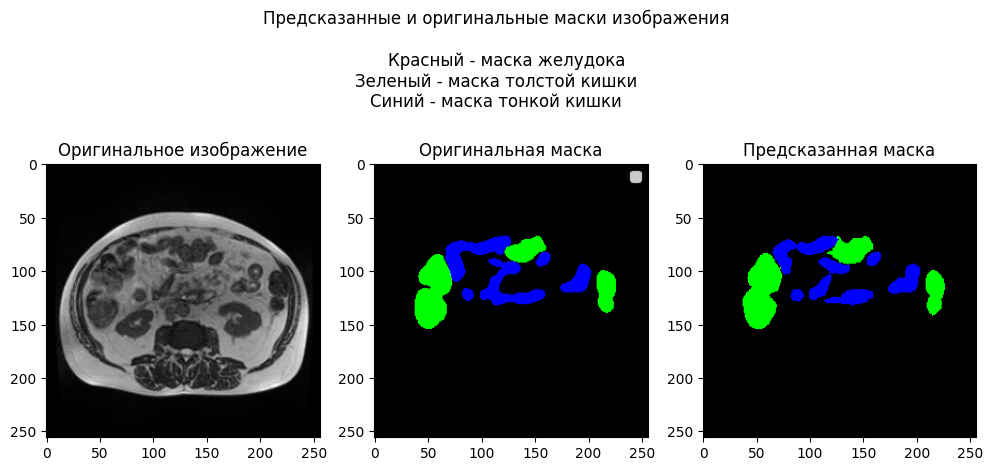

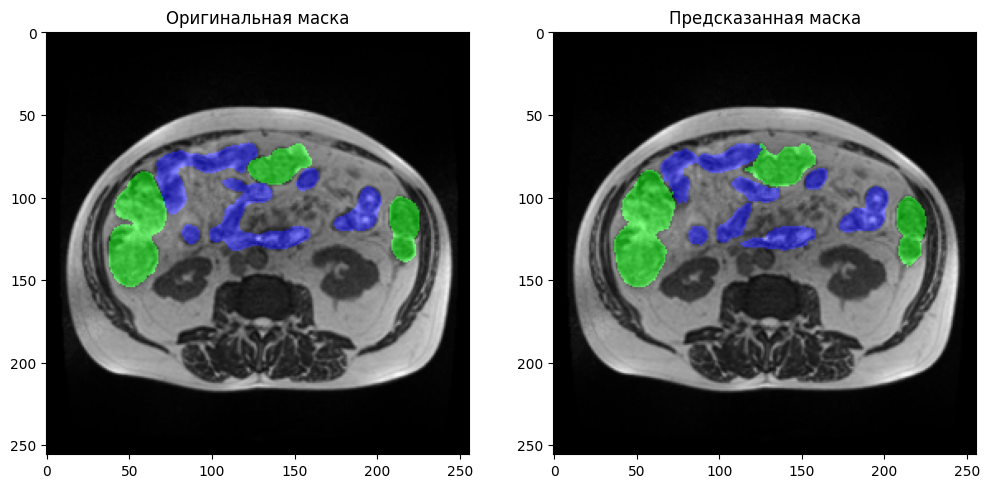

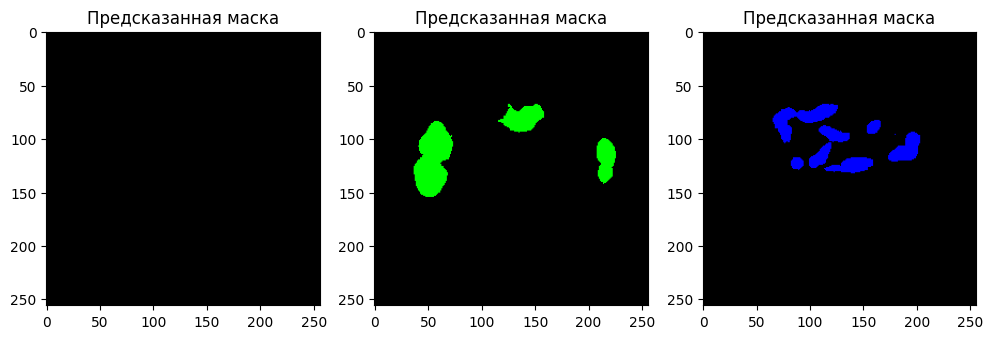

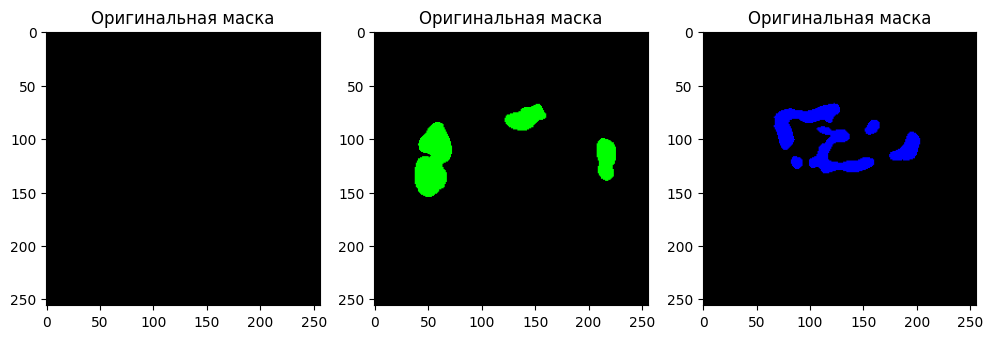

In [108]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Оригинальное изображение')

plt.subplot(1, 3, 2)
plt.imshow(no_img_original)
plt.title('Оригинальная маска')
plt.legend(no_img_original)
plt.subplot(1, 3, 3)
plt.imshow(no_img_predicted)
plt.title('Предсказанная маска')

# Добавление общего заглавия ко всем изображениям
plt.suptitle("""Предсказанные и оригинальные маски изображения\n
    Красный - маска желудока\nЗеленый - маска толстой кишки\nСиний - маска тонкой кишки""")


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(result_original)
plt.title('Оригинальная маска')

plt.subplot(1, 2, 2)
plt.imshow(result_predicted)
plt.title('Предсказанная маска')


plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(colored_predicted_masks[0])
plt.title('Предсказанная маска')

plt.subplot(1, 3, 2)
plt.imshow(colored_predicted_masks[1])
plt.title('Предсказанная маска')

plt.subplot(1, 3, 3)
plt.imshow(colored_predicted_masks[2])
plt.title('Предсказанная маска')

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(colored_original_masks[0])
plt.title('Оригинальная маска')

plt.subplot(1, 3, 2)
plt.imshow(colored_original_masks[1])
plt.title('Оригинальная маска')

plt.subplot(1, 3, 3)
plt.imshow(colored_original_masks[2])
plt.title('Оригинальная маска')


plt.show()